<a href="https://colab.research.google.com/github/lenabic/bsd23_bichler_lena/blob/main/SDM_NetflixTitles_Bichler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Dataset

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Path to dataset files:", path)

100%|██████████| 1.34M/1.34M [00:00<00:00, 106MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [9]:
file_path = "/root/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5/netflix_titles.csv"
df = pd.read_csv(file_path)

# Data Cleaning

## Drop Duplicates

In [10]:
# see the sum before
df.shape

(8807, 12)

In [11]:
dt = df.drop_duplicates()

In [12]:
# sum after dropping duplicates
dt.shape

(8807, 12)

after checking if there are any duplicates before deleting them from df, you can see that there are no identical duplicates so this is clean

## Consistency

check the columns to make sure the values of them are consistent

### Check Type for Consistency

In [13]:
df.type.value_counts()

,count
type,
Movie,6131
TV Show,2676


type only uses two values - movie and tv show. this column is "clean".

### Check Rating for Consistency

In [14]:
# list all the different rating types used in this data set
df.rating.value_counts()

,count
rating,
TV-MA,3207
TV-14,2160
TV-PG,863
R,799
PG-13,490
TV-Y7,334
TV-Y,307
PG,287
TV-G,220


There are some obvious values that do not make sese: some values use time instead of the reating. These wrong ones need to be removed


some rating types seem obviousöy wrong (minute types - 74 min 84 min 66 min). There might have been a mix up in what column these belong in. Regardless, these rows are faulty and will be removed.

In [15]:
# move all invalid ratings into a new data set
invalid_ratings = df[df['rating'].str.contains(r'^\d+ min$', na=False)]

In [16]:
invalid_ratings

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


In [17]:
# remove the invalid ratings from df
df = df.drop(invalid_ratings.index)

In [18]:
# check to see if it was done correctly
df.rating.value_counts()

,count
rating,
TV-MA,3207
TV-14,2160
TV-PG,863
R,799
PG-13,490
TV-Y7,334
TV-Y,307
PG,287
TV-G,220


The three rows have now been removed



---



New rating types

Because the other types of ratings all use different rating systems that mean somewhat the same, I have decided to combine the ratings that fit together to make it more überschaubar. This is because:


*   less rating types make it easier to analyse
*   the rating types mean the same anyway for different age groups, they just use a different method to describe it



In [19]:
# rename all TV-MA, R and NC-17 to Adult
df['rating'] = df['rating'].replace(['TV-MA', 'R', 'NC-17'], 'Adult')

In [20]:
# rename all TV-14 and PG-13 to Teen/Young Adult
df['rating'] = df['rating'].replace(['TV-14', 'PG-13'], 'Teen/Young Adult')

In [21]:
# rename all TV-PG, PG, TV-G, G to Family Friendly
df['rating'] = df['rating'].replace(['TV-PG', 'PG', 'TV-G', 'G'], 'Family Friendly')

In [22]:
# rename all TV-Y7, TV-Y, TV-Y7-FV to Kids
df['rating'] = df['rating'].replace(['TV-Y7', 'TV-Y', 'TV-Y7-FV'], 'Kids')

In [23]:
# rename all NR and UR to Unrated
df['rating'] = df['rating'].replace(['NR', 'UR'], 'Unrated')

In [24]:
# check if done correctly
df.rating.value_counts()

,count
rating,
Adult,4009
Teen/Young Adult,2650
Family Friendly,1411
Kids,647
Unrated,83


all rating types have now been made easier and visually better

### Check Duration for Consistency

In [25]:
df.duration.value_counts()

,count
duration,
1 Season,1793
2 Seasons,425
3 Seasons,199
90 min,152
94 min,146
...,...
16 min,1
186 min,1
193 min,1


This uses two types of angabe for duration - one in number of seasons and one in minutes.
 I have decided to convert the season times into the standard length of a season in minutes.

 Google search and asking ai have ergeben, that taken into account the different country types of different durations, a 10 episode season will be used for this calculation as the mean per season, as it would take me too much time to look up each show individually to check how many episodes and minutes there are.

 we assume here, that an epsiode takes 45 minutes on average.

In [26]:
# replace 1 Season with 450 min
df['duration'] = df['duration'].replace('1 Season', '450 min')

In [27]:
df_seasons = df[df['duration'].str.contains('Seasons', na=False)]

In [28]:
df_seasons['num_seasons'] = df_seasons['duration'].str.extract('(\d+)').astype(int)

<ipython-input-28-8df2e30d85c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
df_seasons['duration_in_minutes'] = df_seasons['num_seasons'] * 450

<ipython-input-29-d373ca889af0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
df_seasons['duration'] = df_seasons['duration_in_minutes'].astype(str) + ' min'

<ipython-input-30-8455989ad93d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
df.update(df_seasons[['title', 'duration']])

In [32]:
df.duration.value_counts()

,count
duration,
450 min,1793
900 min,425
1350 min,199
90 min,152
94 min,146
...,...
16 min,1
186 min,1
193 min,1


## Drop Not Needed Columns

There are some columns that are not needed for my evaluation/ analyzation of this data set - show_id, director, cast nd description.

Let's remove them!

In [33]:
df = df.drop(columns='show_id', axis=1)

In [34]:
df = df.drop(columns='director', axis=1)

In [35]:
df = df.drop(columns='cast', axis=1)

In [36]:
df = df.drop(columns='description', axis=1)

In [37]:
df.head()

,type,title,country,date_added,release_year,rating,duration,listed_in
0,Movie,Dick Johnson Is Dead,United States,"September 25, 2021",2020,Teen/Young Adult,90 min,Documentaries
1,TV Show,Blood & Water,South Africa,"September 24, 2021",2021,Adult,900 min,"International TV Shows, TV Dramas, TV Mysteries"
2,TV Show,Ganglands,NaN,"September 24, 2021",2021,Adult,450 min,"Crime TV Shows, International TV Shows, TV Act..."
3,TV Show,Jailbirds New Orleans,NaN,"September 24, 2021",2021,Adult,450 min,"Docuseries, Reality TV"
4,TV Show,Kota Factory,India,"September 24, 2021",2021,Adult,900 min,"International TV Shows, Romantic TV Shows, TV ..."


## Missing Variables - NaN

In [38]:
# cheking how many NaN there are in each column
df.isnull().sum()

,0
type,0
title,0
country,831
date_added,10
release_year,0
rating,4
duration,0
listed_in,0


### NaN in Ratings

In [39]:
# check ratings NaN
df[df['rating'].isnull()]

,type,title,country,date_added,release_year,rating,duration,listed_in
5989,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"January 26, 2017",2017,NaN,37 min,Movies
6827,TV Show,Gargantia on the Verdurous Planet,Japan,"December 1, 2016",2013,NaN,450 min,"Anime Series, International TV Shows"
7312,TV Show,Little Lunch,Australia,"February 1, 2018",2015,NaN,450 min,"Kids' TV, TV Comedies"
7537,Movie,My Honor Was Loyalty,Italy,"March 1, 2017",2015,NaN,115 min,Dramas


as I am taking the NaN as the same thing as Unrated, I will simply add them to the Unrated type.

In [40]:
# rewrite all NaN to Unrated
dt = df['rating'] = df['rating'].fillna('Unrated')

### NaN in Country

In [41]:
# list the NaN in country
df[df['country'].isnull()]

,type,title,country,date_added,release_year,rating,duration,listed_in
2,TV Show,Ganglands,NaN,"September 24, 2021",2021,Adult,450 min,"Crime TV Shows, International TV Shows, TV Act..."
3,TV Show,Jailbirds New Orleans,NaN,"September 24, 2021",2021,Adult,450 min,"Docuseries, Reality TV"
5,TV Show,Midnight Mass,NaN,"September 24, 2021",2021,Adult,450 min,"TV Dramas, TV Horror, TV Mysteries"
6,Movie,My Little Pony: A New Generation,NaN,"September 24, 2021",2021,Family Friendly,91 min,Children & Family Movies
10,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,"September 24, 2021",2021,Adult,450 min,"Crime TV Shows, Docuseries, International TV S..."
...,...,...,...,...,...,...,...,...
8718,Movie,Westside vs. the World,NaN,"August 9, 2019",2019,Adult,96 min,"Documentaries, Sports Movies"
8759,Movie,World's Weirdest Homes,NaN,"February 1, 2019",2015,Family Friendly,49 min,Movies
8783,TV Show,Yoko,NaN,"June 23, 2018",2016,Kids,450 min,Kids' TV
8785,TV Show,YOM,NaN,"June 7, 2018",2016,Kids,450 min,Kids' TV


Due to the fact that I cannot simply assume that with 831 productions they will just be in the majority of the countries, I will add a new section "Not specified"

In [42]:
# put all NaN as a new country type "Not Specified"
df['country'] = df['country'].fillna('Not Specified')

In [43]:
df.country.isnull().sum()

0

In [44]:
# value counts for country
df.country.value_counts()

,count
country,
United States,2815
India,972
Not Specified,831
United Kingdom,419
Japan,245
...,...
"Romania, Bulgaria, Hungary",1
"Uruguay, Guatemala",1
"France, Senegal, Belgium",1


In some cases (e.g.: Country) it is useful for my further analysis to split it into each country using the explode method

In [45]:
# explode method for country
dt['country'] =  df['country'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

### NaN in date_added

In [46]:
df[df['date_added'].isnull()]

,type,title,country,date_added,release_year,rating,duration,listed_in
6066,TV Show,A Young Doctor's Notebook and Other Stories,United Kingdom,NaN,2013,Adult,900 min,"British TV Shows, TV Comedies, TV Dramas"
6174,TV Show,Anthony Bourdain: Parts Unknown,United States,NaN,2018,Family Friendly,2250 min,Docuseries
6795,TV Show,Frasier,United States,NaN,2003,Family Friendly,4950 min,"Classic & Cult TV, TV Comedies"
6806,TV Show,Friends,United States,NaN,2003,Teen/Young Adult,4500 min,"Classic & Cult TV, TV Comedies"
6901,TV Show,Gunslinger Girl,Japan,NaN,2008,Teen/Young Adult,900 min,"Anime Series, Crime TV Shows"
7196,TV Show,Kikoriki,Not Specified,NaN,2010,Kids,900 min,Kids' TV
7254,TV Show,La Familia P. Luche,United States,NaN,2012,Teen/Young Adult,1350 min,"International TV Shows, Spanish-Language TV Sh..."
7406,TV Show,Maron,United States,NaN,2016,Adult,1800 min,TV Comedies
7847,TV Show,Red vs. Blue,United States,NaN,2015,Unrated,5850 min,"TV Action & Adventure, TV Comedies, TV Sci-Fi ..."
8182,TV Show,The Adventures of Figaro Pho,Australia,NaN,2015,Kids,900 min,"Kids' TV, TV Comedies"


Because it is a small amount, I have decided to just delete the NaN date_added

In [47]:
# delete all rows with NaN in date_added
df = df.dropna(subset=['date_added'])

In [48]:
df.isnull().sum()

,0
type,0
title,0
country,0
date_added,0
release_year,0
rating,0
duration,0
listed_in,0


## Shortening

In order to get a more accurate result when doing the Data Modelling, I will be shortening the columns that have more than one thing mentioned in a row (listed_in and country). I assume that the most important country and genre is always the one mentioned first, so I will be shortening the INhalt to just that information.

In [49]:
df['primary_genre'] = df['listed_in'].str.split(',').str[0]

<ipython-input-49-035f66a24cd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
df['primary_country'] = df['country'].str.split(',').str[0]

<ipython-input-50-31d459d9ee9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
df.primary_genre.value_counts()

,count
primary_genre,
Dramas,1600
Comedies,1210
Action & Adventure,859
Documentaries,829
International TV Shows,773
Children & Family Movies,605
Crime TV Shows,399
Kids' TV,386
Stand-Up Comedy,334


In [52]:
df.primary_country.value_counts()

,count
primary_country,
United States,3202
India,1008
Not Specified,830
United Kingdom,627
Canada,271
...,...
Namibia,1
Senegal,1
Luxembourg,1


In [53]:
df.head()

,type,title,country,date_added,release_year,rating,duration,listed_in,primary_genre,primary_country
0,Movie,Dick Johnson Is Dead,United States,"September 25, 2021",2020,Teen/Young Adult,90 min,Documentaries,Documentaries,United States
1,TV Show,Blood & Water,South Africa,"September 24, 2021",2021,Adult,900 min,"International TV Shows, TV Dramas, TV Mysteries",International TV Shows,South Africa
2,TV Show,Ganglands,Not Specified,"September 24, 2021",2021,Adult,450 min,"Crime TV Shows, International TV Shows, TV Act...",Crime TV Shows,Not Specified
3,TV Show,Jailbirds New Orleans,Not Specified,"September 24, 2021",2021,Adult,450 min,"Docuseries, Reality TV",Docuseries,Not Specified
4,TV Show,Kota Factory,India,"September 24, 2021",2021,Adult,900 min,"International TV Shows, Romantic TV Shows, TV ...",International TV Shows,India


I have now created two columns more, to more accurately analyse the listed_in and country columns

# Data Analyziation
Analyzing the Data based on 10 thought out questions

## 1. Which Genres are most commomly used?

In [54]:
df.primary_genre.value_counts().head()

,count
primary_genre,
Dramas,1600
Comedies,1210
Action & Adventure,859
Documentaries,829
International TV Shows,773


The genres most commonly used are Dramas, Comedies, Action & Adventures, closely followed by Documentaries and International TV Shows.

## 2. Are there more Movies or more TV Shows in this list from Netflix repertoire?

In [55]:
# more movies or tv shows
df.type.value_counts()

,count
type,
Movie,6128
TV Show,2666


There are more movies listed in this data set

## 3. How long does it take for a movie/TV show to be added to Netflix? Has that time changed over the years?

In [56]:
# extract release year
dm = df.copy()
dm['year_added'] = pd.to_datetime(dm['date_added'], format='%B %d, %Y', errors='coerce').dt.year

In [57]:
# difference between release year and year added to Netflix
dm['time_to_add'] = dm['year_added'] - dm['release_year']

In [58]:
# mean er year
time_to_add_by_year = dm.groupby('release_year')['time_to_add'].mean().reset_index()

In [59]:
fig = px.line(
    time_to_add_by_year,
    x='release_year',
    y='time_to_add',
    title='Average Time to Add Content to Netflix by Release Year',
    labels={'release_year': 'Release Year', 'time_to_add': 'Average Time to Add (years)'},
    markers=True
)

fig.show()

I looked at the years mean to determine how long it took for content to be added to Netflix. The time in years before Netflix existed is obviously quite high because there was no way to add them before the existense of Netflix.

So, I will only be looking at the dates after 2007 (incl. 2007), the year Netflix was created as they are more relevant. Here you can see that it took quite a while in the beginning to add content to Netflix on average. Now we are in a time were Netflix does a lot of self productions and movies and tv shows are on Netflix quickly. In 2021, the average time was 0.005 years - this is not even a month (0.06 Months).

## 4. Which countries have the most productions?

In [60]:
count = df.primary_country.value_counts()

In [61]:
top_10_countries = count.head(10).reset_index()
top_10_countries.columns = ['country', 'count']

# Visualisierung mit Plotly
fig = px.bar(
    top_10_countries,
    x='count',
    y='country',
    title='Top 10 Countries with the most Netflix Productions',
    labels={'count': 'Number of Productions', 'country': 'Country'},
    color='count',
   )
fig.update_layout(yaxis=dict(categoryorder='total ascending'))
fig.show()

The top 3 countries with the most productions are United States, India and United Kingdom. As seen in the plot, United States clearly is the winner, having 2194 productions more than second place, India.

## 5. Most Common Ratings

In [62]:
df.rating.value_counts()

,count
rating,
Adult,4007
Teen/Young Adult,2647
Family Friendly,1409
Kids,645
Unrated,86


The most common rating is the Adult rating. Teen/ Young Adult takes second place, and third is Family Friendly TV shows/ Movies.

## 6. Are there any relations between Release Year and Movie Duration?

In [63]:
# Filter for Movies
df_movies = df[df['type'] == 'Movie']

In [64]:
# extract numeric duration from strings
df_movies['duration'] = df_movies['duration'].str.extract('(\d+)').astype(float)
# mean per year
mean_duration_per_year = df_movies.groupby('release_year')['duration'].mean().reset_index()

<ipython-input-64-bee237548921>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
# show it in a diagram
fig = px.line(
    mean_duration_per_year,
    x='release_year',
    y='duration',
    title='Average Movie Duration Per Year',
    labels={'release_year': 'Release Year', 'duration': 'Average Duration (min)'}
)

fig.show()

The peak of duration time was reached in 1964 with 200.5 minutes. Since 2002, the duration time has mostly been gradually declining, going from 119.5 min to 92.1 min in 2020. In 2021 the duration time picked up a bit compared to 2020.

## 7. Which Countries dominate certain Genres?

In [66]:
# Group by primary_country and primary_genre and count
country_genre_counts = df.groupby(['primary_country', 'primary_genre']).size().reset_index(name='count')

In [67]:
# Finde dominating genre for every country
dominant_genres = country_genre_counts.loc[country_genre_counts.groupby('primary_country')['count'].idxmax()]

In [68]:
fig = px.bar(
    dominant_genres,
    x='primary_country',
    y='count',
    color='primary_genre',
    title='Dominant Genres by Country on Netflix',
    labels={'count': 'Number of Titles', 'primary_country': 'Country', 'primary_genre': 'Genre'},
    text='primary_genre'
)

fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

Altough it is somewhat hard to identify the top genry of every country, the ones with the most productions are clearly shown.

United States dominates in Documentaries, with 429.

India produces a lot of Dramas, 404.

Japan dominates in the Anime Series, while United Kingdom is king of the British TV Shows.

## 8. Which countries produce the most Kids Ratings?

In [69]:
# Filter for "Kids"-Rating
kids_df = df[df['rating'] == 'Kids']

In [70]:
# Count Productions per Country
kids_country_counts = kids_df['primary_country'].value_counts().reset_index()
kids_country_counts.columns = ['primary_country', 'kids_productions']

In [71]:
# Top 10 Countries
print(kids_country_counts.head(10))

  primary_country  kids_productions
0   United States               243
1   Not Specified               178
2          Canada                41
3  United Kingdom                33
4          France                24
5           India                22
6           Japan                21
7     South Korea                16
8       Australia                14
9          Russia                 7


Due to the high amount of productions, the United States dominates many different ratings. Kids Rating is no exception, leading with 243 productions.

The other contenders have a pretty huge gap, the second country Canada only having 41 under it's belt.

## 9. Are there patterns in the frequency of productions based on the month of addition (date_added)?

In [72]:
dm = df.copy()

In [73]:
# bring into date format
dm['date_added'] = pd.to_datetime(dm['date_added'].str.strip(), format='%B %d, %Y', errors='coerce')

In [74]:
# extract month
dm['month_added'] = dm['date_added'].dt.month

In [75]:
# split into TV Shows and Movies
dm_movies = dm[dm['type'] == 'Movie']
dm_tv_shows = dm[dm['type'] == 'TV Show']

In [76]:
# count per month
movies_monthly = dm_movies.groupby('month_added').size().reset_index(name='count')
tv_shows_monthly = dm_tv_shows.groupby('month_added').size().reset_index(name='count')

In [77]:
# whole amount of movies and tv shows
total_movies = movies_monthly['count'].sum()
total_tv_shows = tv_shows_monthly['count'].sum()

In [78]:
# percentage per month
movies_monthly['percentage'] = (movies_monthly['count'] / total_movies) * 100
tv_shows_monthly['percentage'] = (tv_shows_monthly['count'] / total_tv_shows) * 100

In [79]:
# Visualisation of Movies
fig_movies = px.bar(
    movies_monthly,
    x='month_added',
    y='percentage',
    title='Percentage of Movies Added to Netflix per Month',
    labels={'month_added': 'Month', 'percentage': 'Percentage of Movies'},
)

In [80]:
# Visualisation of TV Shows
fig_tv_shows = px.bar(
    tv_shows_monthly,
    x='month_added',
    y='percentage',
    title='Percentage of TV Shows Added to Netflix per Month',
    labels={'month_added': 'Month', 'percentage': 'Percentage of TV Shows'},
    color_discrete_sequence=['green']
)

In [81]:
fig_movies.show()
fig_tv_shows.show()

In [82]:
df.head()

,type,title,country,date_added,release_year,rating,duration,listed_in,primary_genre,primary_country
0,Movie,Dick Johnson Is Dead,United States,"September 25, 2021",2020,Teen/Young Adult,90 min,Documentaries,Documentaries,United States
1,TV Show,Blood & Water,South Africa,"September 24, 2021",2021,Adult,900 min,"International TV Shows, TV Dramas, TV Mysteries",International TV Shows,South Africa
2,TV Show,Ganglands,Not Specified,"September 24, 2021",2021,Adult,450 min,"Crime TV Shows, International TV Shows, TV Act...",Crime TV Shows,Not Specified
3,TV Show,Jailbirds New Orleans,Not Specified,"September 24, 2021",2021,Adult,450 min,"Docuseries, Reality TV",Docuseries,Not Specified
4,TV Show,Kota Factory,India,"September 24, 2021",2021,Adult,900 min,"International TV Shows, Romantic TV Shows, TV ...",International TV Shows,India


There really seems to not be a prime month where exponentionally more things are added to Netflix.

For Movies, January, April, July and December seem to be the months with the uploads, February being the month with the least.

For TV shows, the first two months of the year seem to be the slower months, the amount picking up in the middle of the year, but also December.

Overall for both types, the amount seems pretty consistently divided throughout the months.

## 10. How have the most common genres changed over the years?

In [83]:
genre_year_counts = df.groupby(['release_year', 'primary_genre'])['primary_genre'].size().reset_index(name='count')

In [84]:
# 3. Identify Top 5 Genres
top_genres = (
    genre_year_counts.groupby('primary_genre')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

In [85]:
top_genre_data = genre_year_counts[genre_year_counts['primary_genre'].isin(top_genres)]

In [86]:
# 4. show Graph
fig = px.line(
    top_genre_data,
    x='release_year',
    y='count',
    title='Development of the most frequently represented genres (primary_genre) over the years',
    labels={'release_year': 'Year', 'count': 'Amount', 'primary_genre': 'Genre'},
    color='primary_genre',
)

fig.show()

This graph shows the evolution of the 5 most used genres, depicting their amount released throughout the years. The genres reached their highest point all in between 2017-2020. The most dominating genre for a few years has been the Dramas.

# Data Modelling

## Import Neccessary

In [87]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from  sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

## Predict Whether a Production has a Kids or Adult Rating

I will filter for only the Kids and Adult Ratings, because I want to only predict between those two.

Furthermore I will also remove some columns that are not neccessary.

In [88]:
# filter for only Kids and Adult rating
df_filtered = df[df['rating'].isin(['Kids', 'Adult'])]

In [89]:
# drop date_added from df_filtered
df_filtered = df_filtered.drop(columns=['date_added'])

In [90]:
# drop listed_in and country
df_filtered = df_filtered.drop(columns=['listed_in', 'country'])

In [91]:
df_filtered.head()

,type,title,release_year,rating,duration,primary_genre,primary_country
1,TV Show,Blood & Water,2021,Adult,900 min,International TV Shows,South Africa
2,TV Show,Ganglands,2021,Adult,450 min,Crime TV Shows,Not Specified
3,TV Show,Jailbirds New Orleans,2021,Adult,450 min,Docuseries,Not Specified
4,TV Show,Kota Factory,2021,Adult,900 min,International TV Shows,India
5,TV Show,Midnight Mass,2021,Adult,450 min,TV Dramas,Not Specified


Target variable (y) is "rating" (Kids or Adult). I want to predict whether a production has the "Kids" or "Adult" rating.

All other columns in this dataset are features (X) to train the model.

In [92]:
y = df_filtered[['rating']]  # variable I will filter for
X = df_filtered.drop(columns=['rating']) # features, all except rating

In [93]:
# change into numeric
X = pd.get_dummies(X, drop_first=True)

In [94]:
# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

### with Descision Tree

The decision tree is well suited for my classification task because it can work with both categorical and numerical data.

In [95]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=4)

In [96]:
# train model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [97]:
# Prediction
y_pred = clf.predict(X_test)

In [98]:
# evaluate Prediction
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label="Kids") # needs a certain label

print(f"Decision Tree Accuracy: {accuracy}")
print(f"Decision Tree F1 Score: {f1}")

Decision Tree Accuracy: 0.9828115408225906
Decision Tree F1 Score: 0.9342723004694836


[Text(0.75, 0.9, 'x[4845] <= 0.5\ngini = 0.241\nsamples = 3023\nvalue = [2600, 423]'),
 Text(0.625, 0.7, 'x[4832] <= 0.5\ngini = 0.14\nsamples = 2813\nvalue = [2600.0, 213.0]'),
 Text(0.6875, 0.8, 'True  '),
 Text(0.5, 0.5, 'x[4847] <= 0.5\ngini = 0.046\nsamples = 2663\nvalue = [2600.0, 63.0]'),
 Text(0.25, 0.3, 'x[4830] <= 0.5\ngini = 0.031\nsamples = 2633\nvalue = [2591, 42]'),
 Text(0.125, 0.1, 'gini = 0.019\nsamples = 2575\nvalue = [2550.0, 25.0]'),
 Text(0.375, 0.1, 'gini = 0.414\nsamples = 58\nvalue = [41, 17]'),
 Text(0.75, 0.3, 'x[0] <= 2018.5\ngini = 0.42\nsamples = 30\nvalue = [9, 21]'),
 Text(0.625, 0.1, 'gini = 0.346\nsamples = 27\nvalue = [6, 21]'),
 Text(0.875, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.75, 0.5, 'gini = 0.0\nsamples = 150\nvalue = [0, 150]'),
 Text(0.875, 0.7, 'gini = 0.0\nsamples = 210\nvalue = [0, 210]'),
 Text(0.8125, 0.8, '  False')]

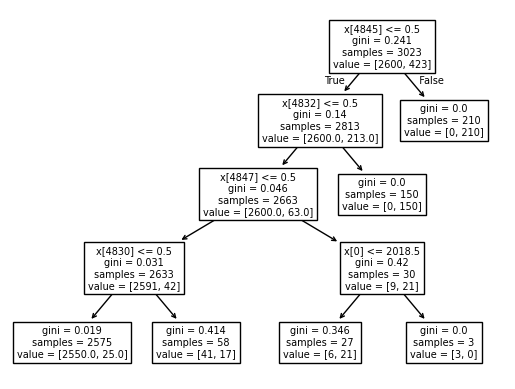

In [99]:
tree.plot_tree(clf)

Both the Decision Tree Accuracy and the F1 Score have a goos score, meaning the decision tree model that works well.

### with K Nearest Neighbor

I also wanted to compare and contrast the accuracy of the Decision Tree, so I decided on kNN as my second evaluation.

In [100]:
# K-Nearest Neighbors Classifier
cl2 = KNeighborsClassifier(n_neighbors=33)

In [101]:
# Trainiere the model
cl2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KNeighborsClassifier(n_neighbors=33)

In [102]:
# Prediction
y_pred2 = cl2.predict(X_test)

In [103]:
# Evaluate
f1_knn = f1_score(y_test, y_pred2, pos_label="Kids")

print(f"kNN F1 Score: {f1_knn}")

kNN F1 Score: 0.784741144414169


The kNN F1 Score is significantly lower than the score with the Decision tree. This type of evaluation does not perform as well.

### Comparison between the Two methods

In [104]:
print(f"Decision Tree F1 Score: {f1}")
print(f"kNN F1 Score: {f1_knn}")

Decision Tree F1 Score: 0.9342723004694836
kNN F1 Score: 0.784741144414169


The decision tree has a higher F1 score (0.93) compared to the KNN model (0.78). This means that the decision tree is overall better at distinguishing between the classes "Adult" and "Kids".